# Neural & Behavioral Modeling - Week 8 (Exercises)
by Cheng-Kuang, Wu (r10922186@ntu.edu.tw)

In [108]:
%config IPCompleter.greedy=True 
%matplotlib inline

from typing import List, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import *

sns.set_theme()

## 1 InStar Learning (4 points)
Try to replicate Fig.2 of <a href=https://arxiv.org/pdf/1612.03270.pdf>[1]</a> = Fig. 3A of <a href=https://sci-hub.se/10.1126/science.1212003>[2]</a>:

[1] Huang, T. R. (2016). Hebbian plasticity for improving perceptual decisions. arXiv preprint arXiv:1612.03270.

[2] Shibata, K., Watanabe, T., Sasaki, Y., & Kawato, M. (2011). Perceptual learning incepted by decoded fMRI neurofeedback without stimulus presentation. Science, 334(6061), 1413-1415.

In [90]:
import torch # use PyTorch for learning
from torch import tensor as t

# Blueprints for the 3 patterns
class Pattern(object):
    # class attributes
    pid2orientation = ["-60", "Target", "+60"] # mapping from pattern ID to the orientation

    def __init__(self, pid: int, sn_ratio: float):
        self.pid = pid # pattern ID
        self.orientation = self.pid2orientation[pid]
        self.sn_ratio = sn_ratio

    # Return the 3-dimensional one-hot representation (according to its pid) (plus the random noise)
    def representation(self):
        v = torch.zeros(size=(len(self.pid2orientation),))
        v[self.pid] = 1.0 # one-hot
        v += 1 / self.sn_ratio * torch.rand(size=(len(self.pid2orientation),)) # random noise (scale inverse to the signal-to-noise ratio)
        return v

class Participant(object):
    # Learning rate shared across individuals
    lr = 0.01

    def __init__(self, initial_match: float):
        self.initial_match = initial_match # initial degree of match to each pattern (i.e., the participant's original "image" of the 3 patterns)
        self.weights = torch.zeros(size=(len(Pattern.pid2orientation), len(Pattern.pid2orientation))) # i.e., the weights for category prototypes
        self.init_weight(initial_match)

    # Initialize the weights according to the initial match (e.g., sample from a normal distribution)
    def init_weight(self, match: float) -> None:
        for pid in range(len(Pattern.pid2orientation)):
            match_degree = torch.normal(mean=t(match), std=t(0.05)).item()
            other_degree = (1 - match_degree) / 2
            self.weights[pid] = other_degree
            self.weights[pid][pid] = match_degree
    
    # Observe a pattern and perform in-star learning
    def learn(self, pattern: Pattern) -> tuple: # return the updated weights and the score
        pattern_vec = pattern.representation()
        scores, pred = self.predict(pattern_vec)
        self.weights[pred] += self.lr * scores[pred] * (pattern_vec - self.weights[pred]) # i.e., W += y * (x - W)
        return self.weights[pred], scores[pred]
    
    def predict(self, pattern_vec: torch.Tensor) -> tuple: # return the raw scores and the pid
        scores = torch.matmul(pattern_vec, self.weights.T)
        pred = scores.argmax() # the pid of the highest similarity score
        return scores, pred

class Simulation(object):

    def __init__(self, pids: List[int], sn_ratios: List[float], n_participant: int, initial_match: float, n_trial: int):
        self.pids = pids
        self.sn_ratios = sn_ratios
        self.n_participant = n_participant
        self.initial_match = initial_match
        self.n_trial = n_trial

        # Initialize patterns and participants
        self.patterns = {pid: {sn_ratio: Pattern(pid, sn_ratio) for sn_ratio in sn_ratios} for pid in pids} # usage: pattern[pid][sn_ratio] == a particular pattern
        self.participants = [Participant(initial_match) for _ in range(n_participant)]

    def run(self, mode: str) -> List[pd.DataFrame]:
        if mode not in ["pre-test", "post-test"]:
            raise ValueError("mode must be pre/post-test")

        results = list()
        for pid in self.pids:
            paccs = list()
            for sn_ratio in self.sn_ratios:
                pattern = self.patterns[pid][sn_ratio]
                n_predict = 0
                n_correct = 0
                for participant in self.participants:
                    if mode == "post-test":
                        participant.init_weight(participant.initial_match) # initalize the weights before learning
                        if pid == 1: # only the target pattern is learned correctly
                            for _ in range(self.n_trial):
                                participant.learn(self.patterns[pid][sn_ratio])

                    _, pred = participant.predict(pattern_vec=pattern.representation())
                    n_predict += 1
                    n_correct += int(pred == pattern.pid)

                accuracy = n_correct / n_predict * 100
                paccs.append(accuracy)

            results.append(paccs)
            
        return results

In [134]:
# Experiment parameters
pids = [0, 1, 2]
sn_ratios = [0.2, 0.4, 0.8, 1.6]

n_participant = 100
initial_match = 0.40

n_simulation = 20
n_trial = 10

# Run the experiment
pre_accs_l = list()
post_accs_l = list()
for sid in range(n_simulation):
    simulation = Simulation(pids, sn_ratios, n_participant, initial_match, n_trial)
    pre_accs = simulation.run(mode="pre-test")
    post_accs = simulation.run(mode="post-test")
    pre_accs_l.append(pre_accs)
    post_accs_l.append(post_accs)

pre_accs_l = np.array(pre_accs_l)
post_accs_l = np.array(post_accs_l)

# Plotting
mean_dfs = list()
std_dfs = list()
for pid in pids:
    mean_pre_accs = pre_accs_l[:, pid, :].mean(axis=0)
    std_pre_accs = pre_accs_l[:, pid, :].std(axis=0)
    mean_post_accs = post_accs_l[:, pid, :].mean(axis=0)
    std_post_accs = post_accs_l[:, pid, :].std(axis=0)
    mean_df = pd.DataFrame({"pre-test": mean_pre_accs, "post-test": mean_post_accs}, index=[str(sn_ratio) for sn_ratio in sn_ratios])
    std_df = pd.DataFrame({"pre-test": std_pre_accs, "post-test": std_post_accs}, index=[str(sn_ratio) for sn_ratio in sn_ratios])
    mean_dfs.append(mean_df)
    std_dfs.append(std_df)

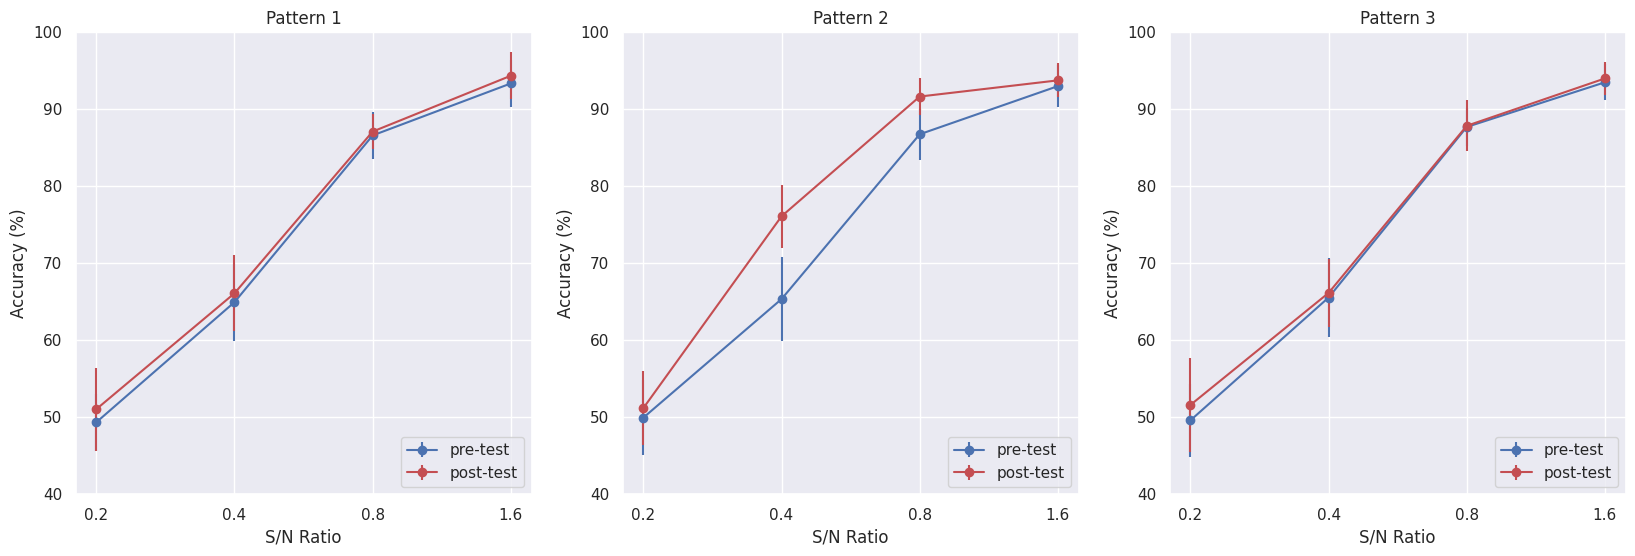

In [137]:
plt.rcParams["figure.figsize"] = (20, 6)
fig, axs = plt.subplots(1, 3)

for pid in pids:
    ax = axs[pid]
    ax.set_ylim(40, 100)
    ax.set_xlabel("S/N Ratio")
    ax.set_ylabel("Accuracy (%)")
    ax.set_title(f"Pattern {pid + 1}")
    for test_type in ["pre-test", "post-test"]:
        ax.errorbar(x=mean_dfs[pid][test_type].index, y=mean_dfs[pid][test_type], yerr=std_dfs[pid][test_type], marker='o', color="r" if test_type == "post-test" else "b", label=test_type)
    ax.legend(loc="lower right")

## 2 PyTorch (4 points)
Read <a href="https://www.pytorchtutorial.com/pytorch-for-numpy-users/">this tutorial</a> first and port the following Instar Learning from NumPy to PyTorch:

In [9]:
# Instar learning:
x = np.array([0.1, 0.3, 0.6])
W = np.random.rand(3)
for i in range(10): # trials 
    y = np.dot(W, x) 
    W += y * (x - W) # postsynaptically gated InStar 
    print(W, y)

[0.10957652 0.66719225 0.33253924] 0.3803414119836088
[0.10564403 0.51640884 0.44236903] 0.4106388718263837
[0.10321197 0.42315644 0.51029355] 0.43090846981167497
[0.10178764 0.36854342 0.55007336] 0.4434442565696063
[0.1009818  0.33764502 0.57257958] 0.4507858059070543
[0.10053514 0.32051882 0.58505421] 0.45493943381702684
[0.10029045 0.31113676 0.59188805] 0.4572416849311023
[0.10015728 0.30603052 0.5956074 ] 0.4585029015607759
[0.10008506 0.30326137 0.59762444] 0.45918932553908226
[0.10004597 0.30176257 0.59871615] 0.4595615785980228


In [16]:
### Write your PyTorch codes here
import torch as t

x = t.tensor([0.1, 0.3, 0.6])
W = t.rand(3)
for i in range(10):
    y = t.dot(W, x)
    W += y * (x - W)
    print(W, y)

tensor([0.1656, 0.3850, 0.3203]) tensor(0.2732)
tensor([0.1444, 0.3575, 0.4110]) tensor(0.3243)
tensor([0.1280, 0.3363, 0.4806]) tensor(0.3683)
tensor([0.1168, 0.3217, 0.5286]) tensor(0.4021)
tensor([0.1096, 0.3125, 0.5590]) tensor(0.4254)
tensor([0.1054, 0.3070, 0.5770]) tensor(0.4401)
tensor([0.1030, 0.3038, 0.5873]) tensor(0.4489)
tensor([0.1016, 0.3021, 0.5931]) tensor(0.4539)
tensor([0.1009, 0.3011, 0.5962]) tensor(0.4566)
tensor([0.1005, 0.3006, 0.5980]) tensor(0.4582)
